In [3]:
# Adapted from https://www.tensorflow.org/tutorials/generative/pix2pix under the following licence:

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [164]:
import tensorflow as tf
from keras import backend as K

import os
import pathlib
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

## Load Dataset

In [8]:
PATH = "Data/SpiralGalaxy/test/"

In [46]:
sample_image_org = tf.io.read_file(str(PATH+'apod_1995-07-24_gray_resized.png'))
sample_image_org = tf.io.decode_png(sample_image_org)
print(sample_image_org.shape)

sample_image_fft = tf.io.read_file(str(PATH+'apod_1995-07-24_fft_norm.png'))
sample_image_fft = tf.io.decode_png(sample_image_fft)
print(sample_image_fft.shape)

(64, 64, 4)
(64, 64, 4)


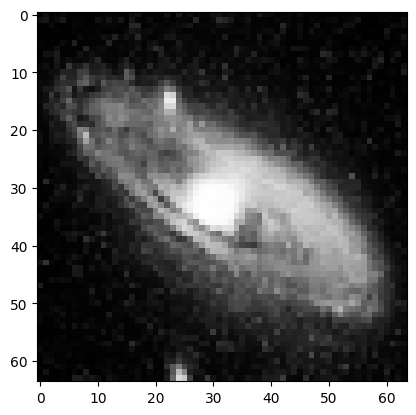

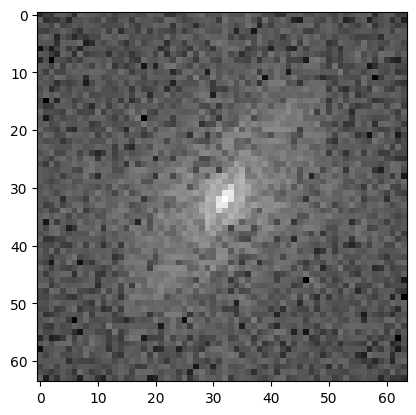

In [51]:
plt.figure()
plt.imshow(sample_image_org)
plt.figure()
plt.imshow(sample_image_fft)

## Preprocessing

In [52]:
training_size = 1200
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
img_size = 64

In [53]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [59]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, img_size, img_size, 3])

  return cropped_image[0], cropped_image[1]

In [60]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [61]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 68, 68)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

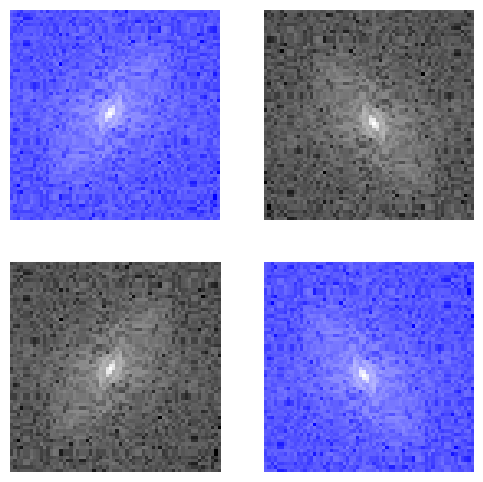

In [72]:
# Check if random_jitter works:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(sample_image_fft, sample_image_org)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp)# / 255.0)
  plt.axis('off')
plt.show()

### Helper functions

In [73]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [74]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [201]:
# Split train, test and validation datasets:

train_dataset = tf.data.Dataset.list_files(str(PATH + '/train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: Data/SpiralGalaxy/test//train/*.jpg'

In [202]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH + '/test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH + '/val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: Data/SpiralGalaxy/test//val/*.jpg'

## Build Generator

In [236]:
OUTPUT_CHANNELS = 3

In [237]:
# Encoder (downsample):
K.set_image_data_format('channels_first')

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, data_format="channels_last",
                             use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [238]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(tf.cast(sample_image_fft, float), 0))
#down_result = down_model(tf.expand_dims(sample_image, 0))
print (down_result.shape)

(1, 64, 64, 3)


In [239]:
# Decoder (upsample):

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    data_format="channels_last",
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [240]:
up_model = upsample(3, 4, apply_dropout=True)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [242]:
# Define generator:
def Generator():
  inputs = tf.keras.layers.Input(shape=[64, 64, 3])


    # Maybe increase for 512x512 when using larger images
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
    downsample(128, 4),  # (batch_size, 32, 32, 128)
    downsample(256, 4),  # (batch_size, 16, 16, 256)
    downsample(256, 4),  # (batch_size, 8, 8, 256)
    downsample(256, 4),  # (batch_size, 4, 4, 256)
    downsample(256, 4),  # (batch_size, 2, 2, 256)
    downsample(256, 4),  # (batch_size, 1, 1, 256)
  ]


  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 512)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
    upsample(512, 4),  # (batch_size, 8, 8, 512)
    upsample(512, 4),  # (batch_size, 16, 16, 256)
    upsample(256, 4),  # (batch_size, 32, 32, 128)
    upsample(128, 4),  # (batch_size, 64, 64, 64)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [244]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 128, 128, 512), (None, 64, 64, 256)]